# **STUDENT AI** - EDA
Exploratory Data Analysis

## Objectives

Conduct Exploratory analysis of the data to glean insights into how it might be used to solve the business case. Final objective is to identify significant variables to train the model on.

## Inputs

Cleaned Dataset from previous notebook.

## Outputs

None


### Install new libraries needed for EDA

---

# Import required libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import ppscore as pps
import pingouin as pg
import scipy.stats as stats
#from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from feature_engine import transformation as vt
from sklearn.pipeline import Pipeline

print('All Libraries Loaded')

# set default diagram size for matplotlib
plt.rcParams['figure.figsize'] = [3, 3]
colors = ['red', 'blue', 'green', 'orange', 'purple','yellow']

All Libraries Loaded


# Load Clean Dataset

### Set the working directory to notebook parent folder
If the output does not match, click **'clear all outputs'** and then **'restart'** the notebook. 
Then run cells from top to bottom.

In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('If correct, Active Directory should read: /workspace/student-AI')
print(f"Active Directory: {current_dir}")

If correct, Active Directory should read: /workspace/student-AI
Active Directory: /workspace/student-AI


### Load cleaned dataset

In [3]:
df = pd.read_csv(f"outputs/dataset/Expanded_data_with_more_features_clean.csv")
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,C,bachelor,standard,not completed,married,regularly,yes,3,schoolbus,Less than 5 hours,71,71,74
1,female,C,college,standard,not completed,married,sometimes,yes,0,schoolbus,Between 5-10 hours,69,90,88
2,female,B,masters,standard,not completed,single,sometimes,yes,4,schoolbus,Less than 5 hours,87,93,91
3,male,A,associates,free,not completed,married,never,no,1,schoolbus,Between 5-10 hours,45,56,42
4,male,C,college,standard,not completed,married,sometimes,yes,0,schoolbus,Between 5-10 hours,76,78,75


### Add mean score to be able to compare all 3 scores as a single value against the features

In [4]:
df['MeanScore'] = df[['MathScore', 'ReadingScore', 'WritingScore']].mean(axis=1).round().astype(int)
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore,MeanScore
0,female,C,bachelor,standard,not completed,married,regularly,yes,3,schoolbus,Less than 5 hours,71,71,74,72
1,female,C,college,standard,not completed,married,sometimes,yes,0,schoolbus,Between 5-10 hours,69,90,88,82
2,female,B,masters,standard,not completed,single,sometimes,yes,4,schoolbus,Less than 5 hours,87,93,91,90
3,male,A,associates,free,not completed,married,never,no,1,schoolbus,Between 5-10 hours,45,56,42,48
4,male,C,college,standard,not completed,married,sometimes,yes,0,schoolbus,Between 5-10 hours,76,78,75,76


## Individual Feature Analysis vs Target Variables (Math, Reading & Writing Score)

### Custom Function to save created plots to disk and overwrite any updates
Saving plots to disk allows later loading in streamlit dashboard 

In [8]:
from pandas.plotting import table

def save_plot(figure, filename, directory='outputs/images/plots'):
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Define the full path
    filepath = os.path.join(directory, filename)

    # If a file with the same name already exists, remove it
    if os.path.isfile(filepath):
        os.remove(filepath)

    # Save the figure
    figure.savefig(filepath, bbox_inches='tight')

In [9]:
# define custom function to plot categorical variables based on column name
def plot_category_distribution(column):
    
    palette = 'Set2'
    sns.set_palette(palette)
    sns.countplot(x=column, data=df)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    save_plot(plt, f'{column}-distribution.png')
    plt.show()

    # Create a figure and 4 subplots
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))

    # Box plots
    sns.boxplot(ax=axs[0], x=column, y='MathScore', data=df)
    axs[0].set_title('Math Score')
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

    sns.boxplot(ax=axs[1], x=column, y='ReadingScore', data=df)
    axs[1].set_title('Reading Score')
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')

    sns.boxplot(ax=axs[2], x=column, y='WritingScore', data=df)
    axs[2].set_title('Writing Score')
    axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')
    
    sns.boxplot(ax=axs[3], x=column, y='MeanScore', data=df)
    axs[3].set_title('Mean Score')
    axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    save_plot(plt, f'{column}-boxplot.png')
    plt.show()

    # print scores compared to the given feature
    df_grouped = df.groupby([column])[['MathScore', 'ReadingScore', 'WritingScore', 'MeanScore']].agg(np.mean)
    df_sorted = df_grouped.sort_values(by='MeanScore', ascending=False)
    
    styled_df = df_sorted.style.background_gradient(cmap='Blues')
    display(styled_df)
    
    mean_max = df_sorted['MeanScore'].iloc[0]
    mean_min = df_sorted['MeanScore'].iloc[-1]
    spread = mean_max - mean_min
    spread_rounded = round(spread, 2)
    print(f'Mean Spread: {spread_rounded}')



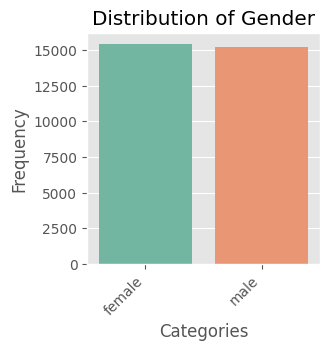

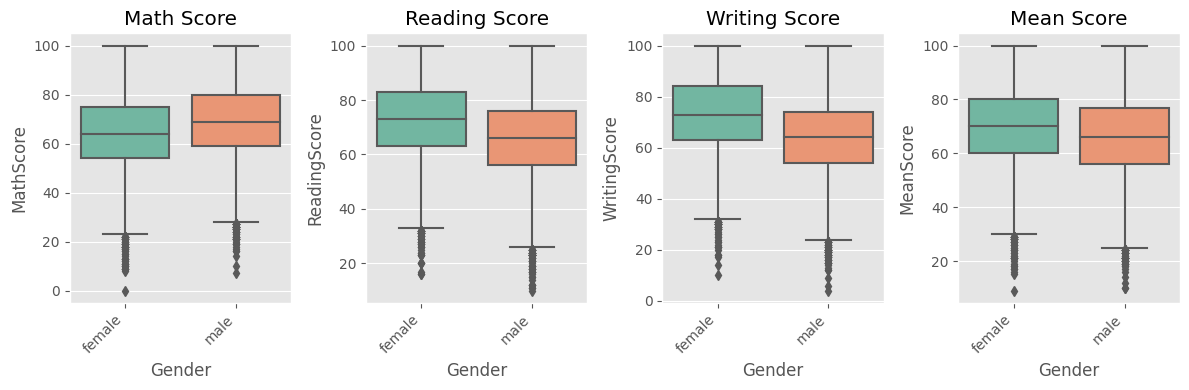

,MathScore,ReadingScore,WritingScore,MeanScore
Gender,,,,
female,64.080654,72.853216,72.856457,69.928683
male,69.069856,65.854571,63.920418,66.280147


Mean Spread: 3.65


In [10]:
plot_category_distribution('Gender')

#### The data is well balanced and shows that females have an overall better performance, but tend to have lower maths skills.
**I hypothesize that gender will not have a very large impact on the predicted score.**

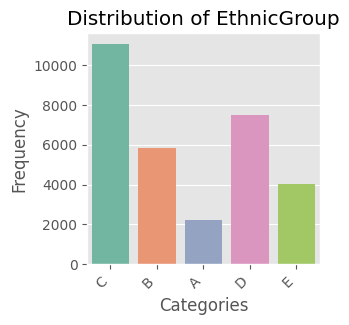

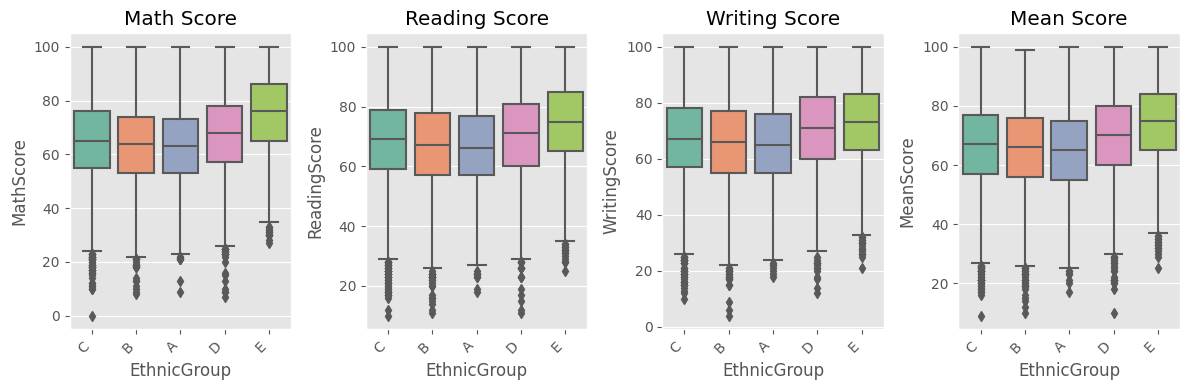

,MathScore,ReadingScore,WritingScore,MeanScore
EthnicGroup,,,,
E,75.298936,74.251423,72.677060,74.074487
D,67.666400,70.382247,70.890844,69.640944
C,64.943811,68.517734,67.149294,66.873326
B,63.490216,67.320460,65.895125,65.567285
A,62.991888,66.787742,65.251915,65.000000


Mean Spread: 9.07


In [11]:
plot_category_distribution('EthnicGroup')

#### This data is not balanced as group C far outnumbers group A ... this will need to be adjusted prior to training the models, as it would unfarely give group C a higher significance in predicting the student performance.

Group E shows the highest mean score and is significantly better performing in school.<br>
Group A shows the least performance with a mean score almost 10% lower.<br>

**I hypothesize that Ethnic Group should have a significant influence on the predicted score.**

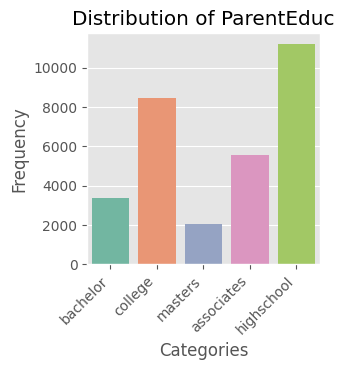

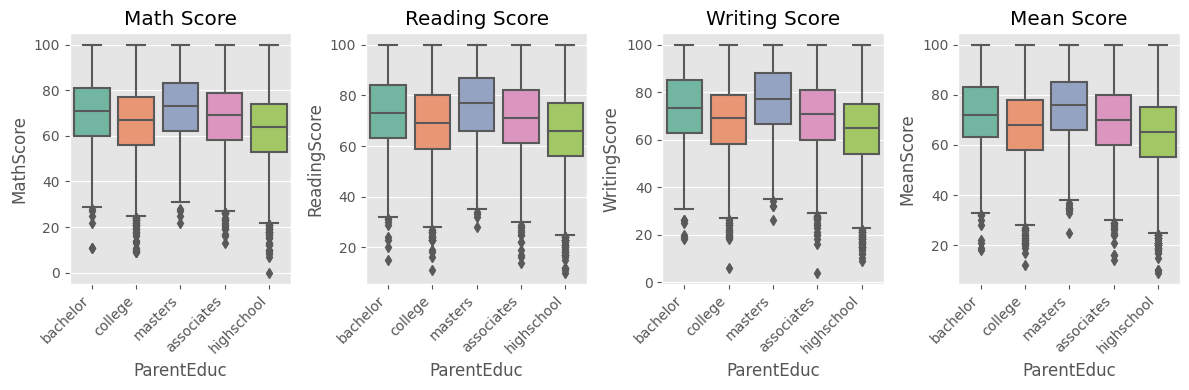

,MathScore,ReadingScore,WritingScore,MeanScore
ParentEduc,,,,
masters,72.336134,75.832921,76.356896,74.839348
bachelor,70.466627,73.062020,73.331069,72.281748
associates,68.365586,71.124324,70.299099,69.931712
college,66.445978,69.189667,68.456711,68.026303
highschool,63.523920,66.375312,64.540343,64.813549


Mean Spread: 10.03


In [12]:
plot_category_distribution('ParentEduc')

#### This data is not balanced and will need to be adjusted prior to training the models, as it would unfarely give students with parents with some college higher emphasis in predicting the student performance.

Parents with a masters degree have the lowest frequency, but tend to have children that outperform all other students.

**I hypothesize that parental education should have a significant influence on the predicted score.**

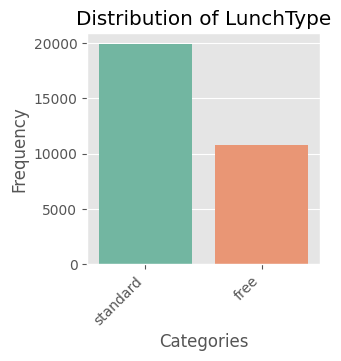

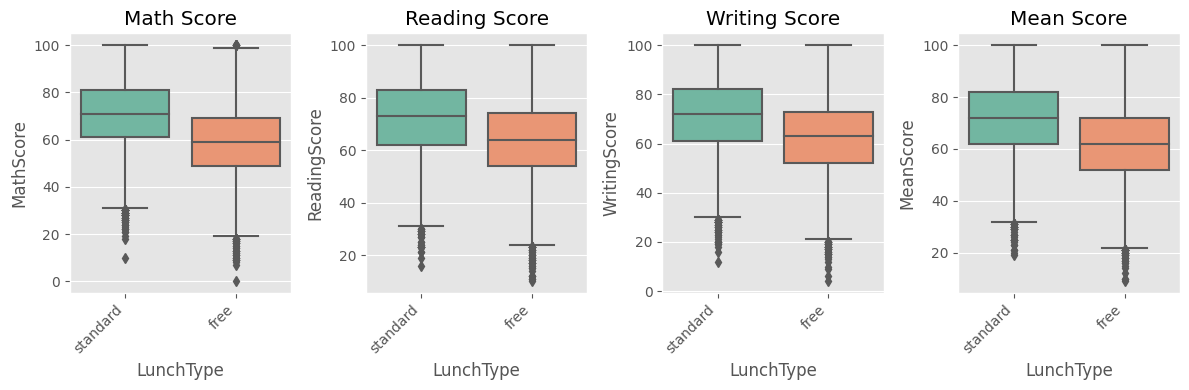

,MathScore,ReadingScore,WritingScore,MeanScore
LunchType,,,,
standard,70.709370,72.175634,71.529716,71.469982
free,58.862332,64.189735,62.650522,61.899683


Mean Spread: 9.57


In [13]:
plot_category_distribution('LunchType')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students who receive a standard lunch.

Students who receive a lunch from their parents (standard) are on average 10% better then students who do not. This is a very generalized indicator of economic well being of the family.<br>
the assumption can be made that parents who do not need to rely on free school lunch programs can afford not only a bespoke lunch meal, but also other benficiary activities such as purchasing study guides, better access to internet / PCs, tutoring etc.

**I hypothesize that LunchType should have a significant influence on the predicted score.**

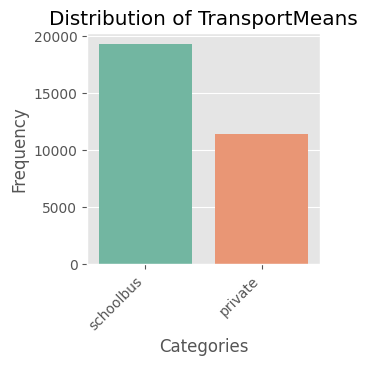

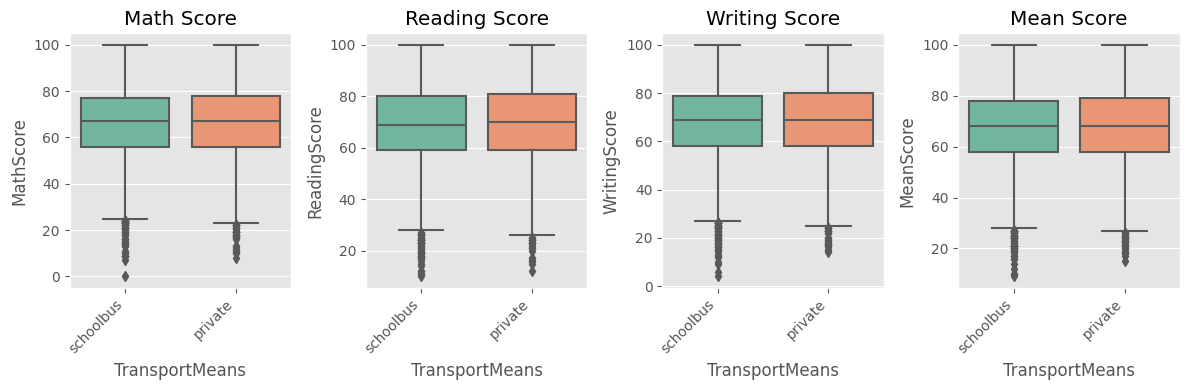

,MathScore,ReadingScore,WritingScore,MeanScore
TransportMeans,,,,
private,66.511354,69.472364,68.509593,68.163880
schoolbus,66.586130,69.321645,68.365009,68.088957


Mean Spread: 0.07


In [14]:
plot_category_distribution('TransportMeans')

This data is also not balanced, but shows it has no impact on the performance of the students.

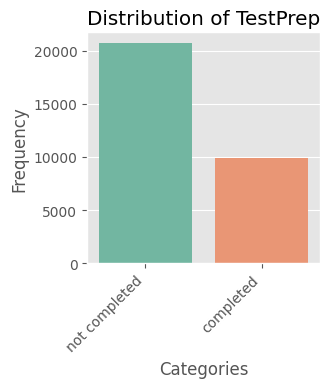

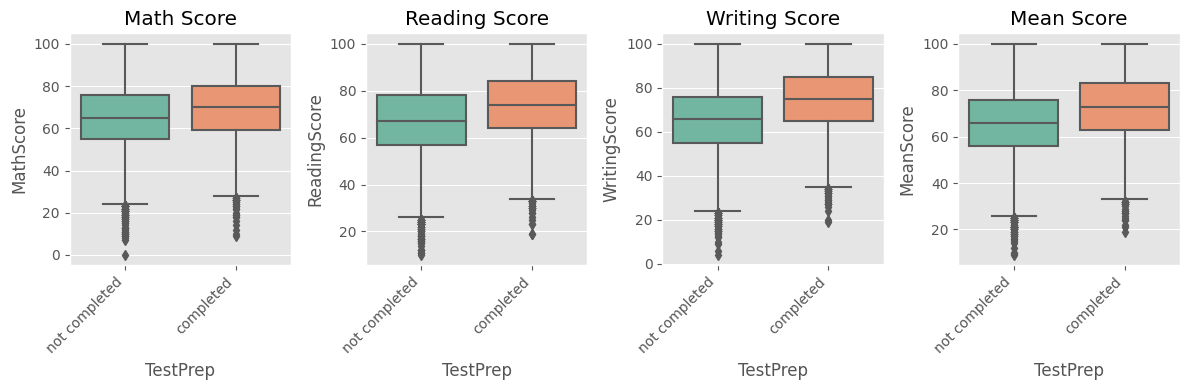

,MathScore,ReadingScore,WritingScore,MeanScore
TestPrep,,,,
completed,69.546660,73.732998,74.703265,72.662280
not completed,65.120323,67.281495,65.394180,65.929227


Mean Spread: 6.73


In [15]:
plot_category_distribution('TestPrep')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students who did not complete their test prep studies.

Faily obviously, students who completed the test preparation perform  on average 7% better in the end.

**I hypothesize that TestPrep should have an influence on the predicted score.**

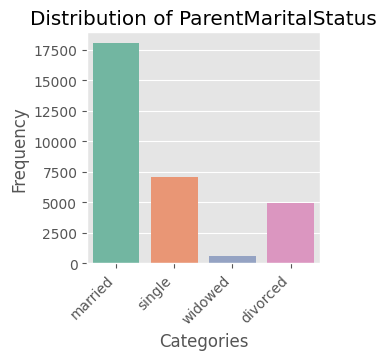

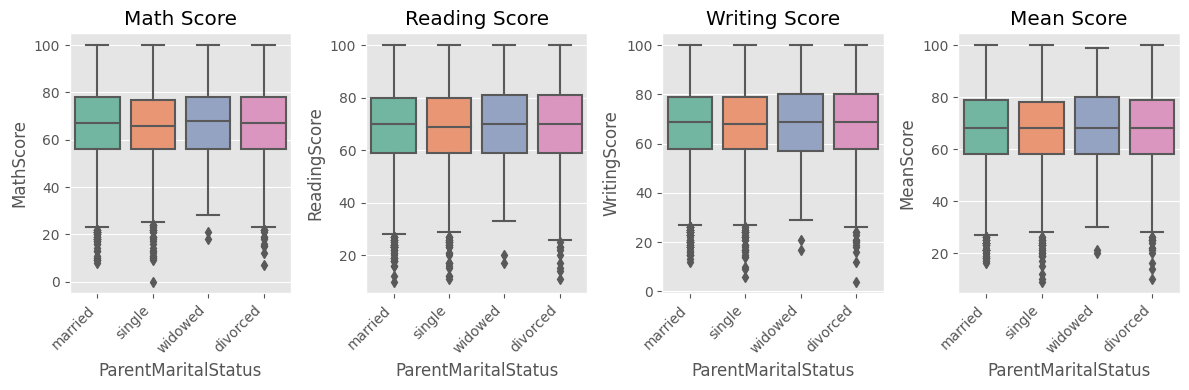

,MathScore,ReadingScore,WritingScore,MeanScore
ParentMaritalStatus,,,,
widowed,67.368866,69.651438,68.563452,68.526227
divorced,66.691197,69.655011,68.799146,68.380972
married,66.650161,69.379561,68.406177,68.144006
single,66.165704,69.157250,68.174440,67.830210


Mean Spread: 0.7


In [16]:
plot_category_distribution('ParentMaritalStatus')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students with married parents.
Also, students with widowed parents seem to be an outlier and might skew the data somewhat.

Based on the mean score, no significant influence of parental marital status can be determined. After confirmation I will likely drop this feature.

**I hypothesize that ParentMaritalStatus should have an no influence on the predicted score.**

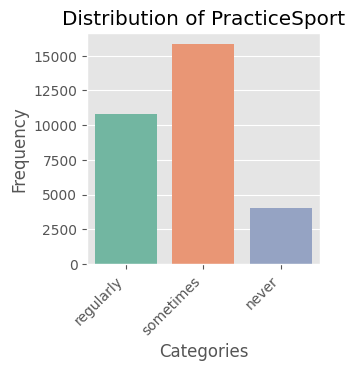

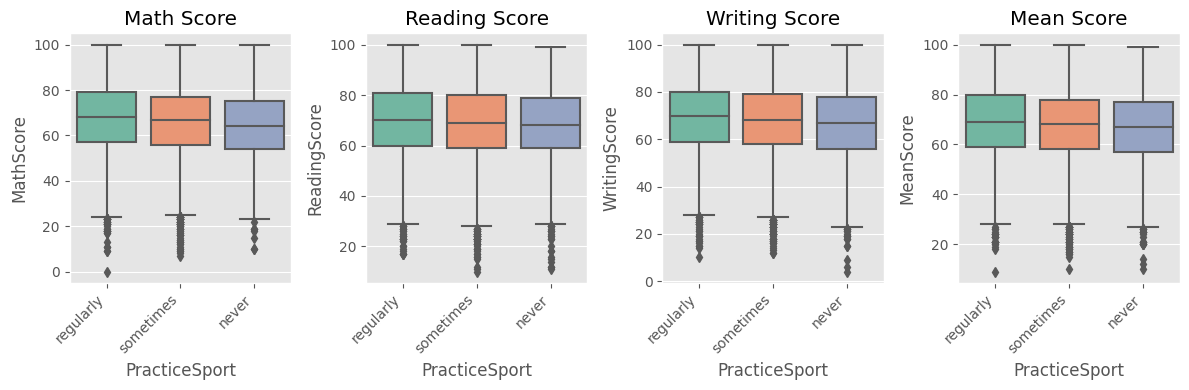

,MathScore,ReadingScore,WritingScore,MeanScore
PracticeSport,,,,
regularly,67.839155,69.943019,69.604003,69.128324
sometimes,66.289258,69.255112,68.090255,67.874968
never,64.171079,68.337662,66.522727,66.346653


Mean Spread: 2.78


In [17]:
plot_category_distribution('PracticeSport')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students who sometimes do sports.

Based on the mean score, only a minor impact of sports can be determined. After confirmation I will likely drop this feature, unless other features aslone are not sufficient.

**I hypothesize that PracticeSport should have only minor influence on the predicted score.**

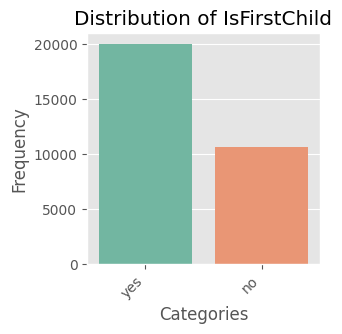

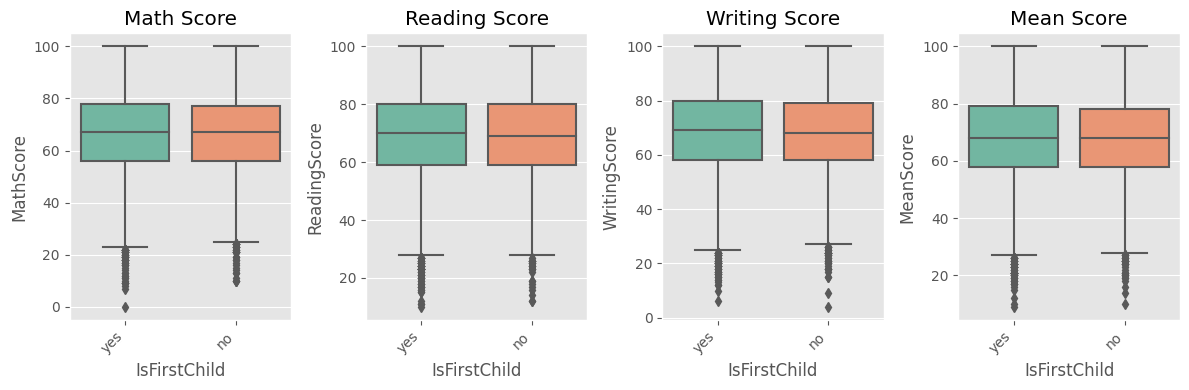

,MathScore,ReadingScore,WritingScore,MeanScore
IsFirstChild,,,,
yes,66.724507,69.508106,68.529371,68.253527
no,66.246832,69.132614,68.210887,67.860160


Mean Spread: 0.39


In [18]:
plot_category_distribution('IsFirstChild')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students who are the first child.

Based on the mean score, only a minor impact of being first child can be determined. After confirmation I will likely drop this feature, unless other features aslone are not sufficient.

**I hypothesize that IsFirstChild should have only minor influence on the predicted score.**

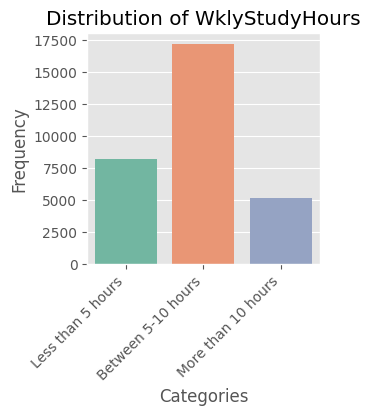

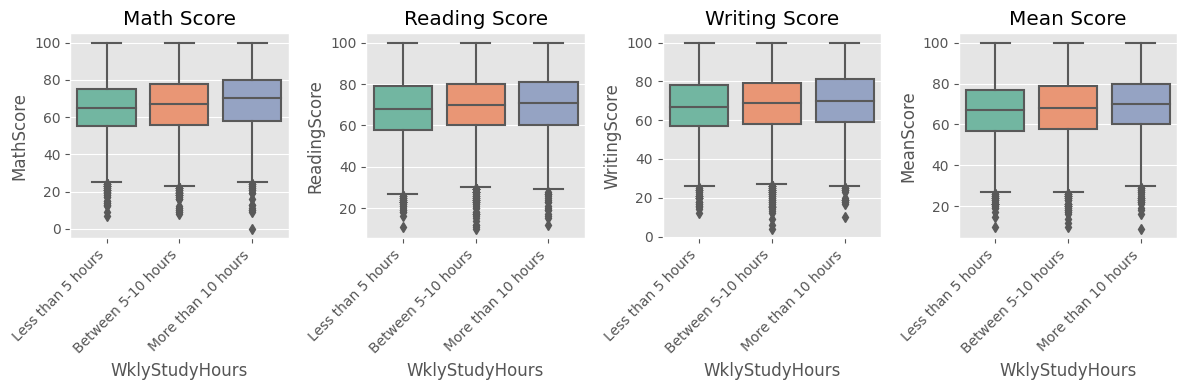

,MathScore,ReadingScore,WritingScore,MeanScore
WklyStudyHours,,,,
More than 10 hours,68.696655,70.365436,69.777778,69.613995
Between 5-10 hours,66.859078,69.654148,68.643800,68.384629
Less than 5 hours,64.580359,68.176135,67.090192,66.611920


Mean Spread: 3.0


In [19]:
plot_category_distribution('WklyStudyHours')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students who study between 5-10 hours.

Based on the mean score, students who study more than 10h per week have on average 3% better score than student who study <5 hours. This is also not a very signigicant difference. A small biad towards mathematics can be seen 4% difference vs 2 or 3 .. indicating that particularly Maths benefits from extra study time.

**I hypothesize that StudyHours should have only minor influence on the predicted score.**

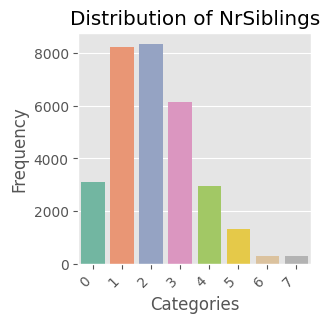

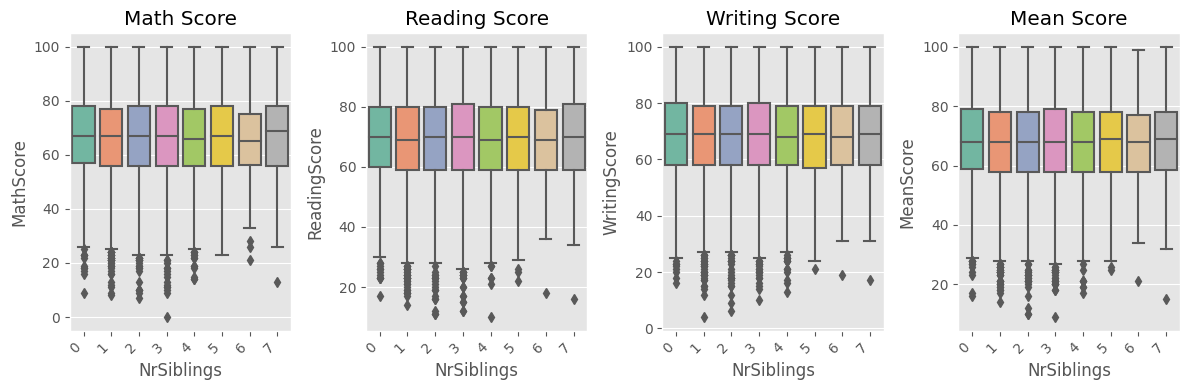

,MathScore,ReadingScore,WritingScore,MeanScore
NrSiblings,,,,
7,67.615120,69.828179,68.986254,68.821306
0,66.819449,69.547812,68.746515,68.369854
3,66.719092,69.488159,68.650498,68.285971
2,66.512557,69.425257,68.441402,68.121382
5,66.630303,69.453788,68.282576,68.119697
1,66.473896,69.259097,68.245345,67.993185
4,66.245495,69.144169,68.073444,67.816729
6,65.917219,68.801325,67.860927,67.562914


Mean Spread: 1.26


In [20]:
plot_category_distribution('NrSiblings')

#### This data is not balanced.

Based on the mean score, there is practically no difference between being an only child (0) or having 7 siblings ... this indicates that this feature has no bearing on the overall student performance and can be dropped.

**I hypothesize that NrSiblings has NO influence on the predicted score.**

## Assess distribution of numerical data

In [22]:
columns = ['MathScore', 'ReadingScore', 'WritingScore','MeanScore']
summaries_dict = {}

for column in columns:
    summary = df[column].describe()
    summaries_dict[column] = summary

# Convert the dictionary of summaries into a DataFrame
summaries_df = pd.DataFrame(summaries_dict)

# Display DataFrames
summaries_df

,MathScore,ReadingScore,WritingScore,MeanScore
count,30641.000000,30641.000000,30641.000000,30641.000000
mean,66.558402,69.377533,68.418622,68.116739
std,15.361616,14.758952,15.443525,14.456619
min,0.000000,10.000000,4.000000,9.000000
25%,56.000000,59.000000,58.000000,58.000000
50%,67.000000,70.000000,69.000000,68.000000
75%,78.000000,80.000000,79.000000,79.000000
max,100.000000,100.000000,100.000000,100.000000


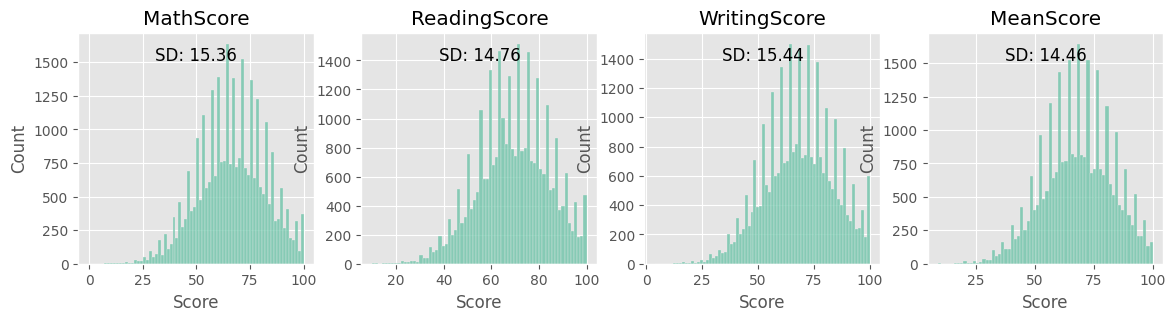

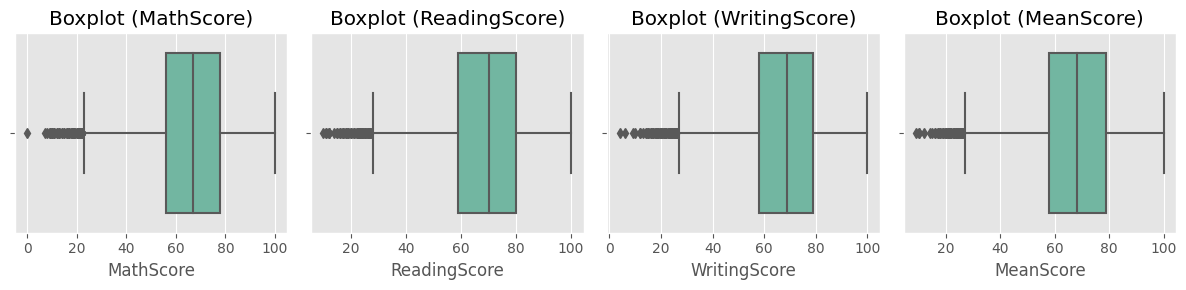

In [28]:
columns = ['MathScore', 'ReadingScore', 'WritingScore','MeanScore']
plt.figure(figsize=(14, 3))

for i, column in enumerate(columns, start=1):
    plt.subplot(1, 4, i) 
    sns.histplot(df[column], fill=True)
    plt.title(column)
    plt.xlabel('Score')
    plt.ylabel('Count')
    
    #add standard deviation to plots
    std_dev = df[column].std()
    plt.text(x=0.5, y=0.9, s=f'SD: {std_dev:.2f}', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=12)

save_plot(plt, f'Numerical-distribution.png')

# add box plots
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
# Columns to plot
for i, col in enumerate(columns):
    ax = axs[i]
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"Boxplot ({col})")

plt.tight_layout()
save_plot(plt, f'Numerical-boxplots.png')
plt.show()

### Create a subplot of KDE diagrams to visualize density/concentration of data

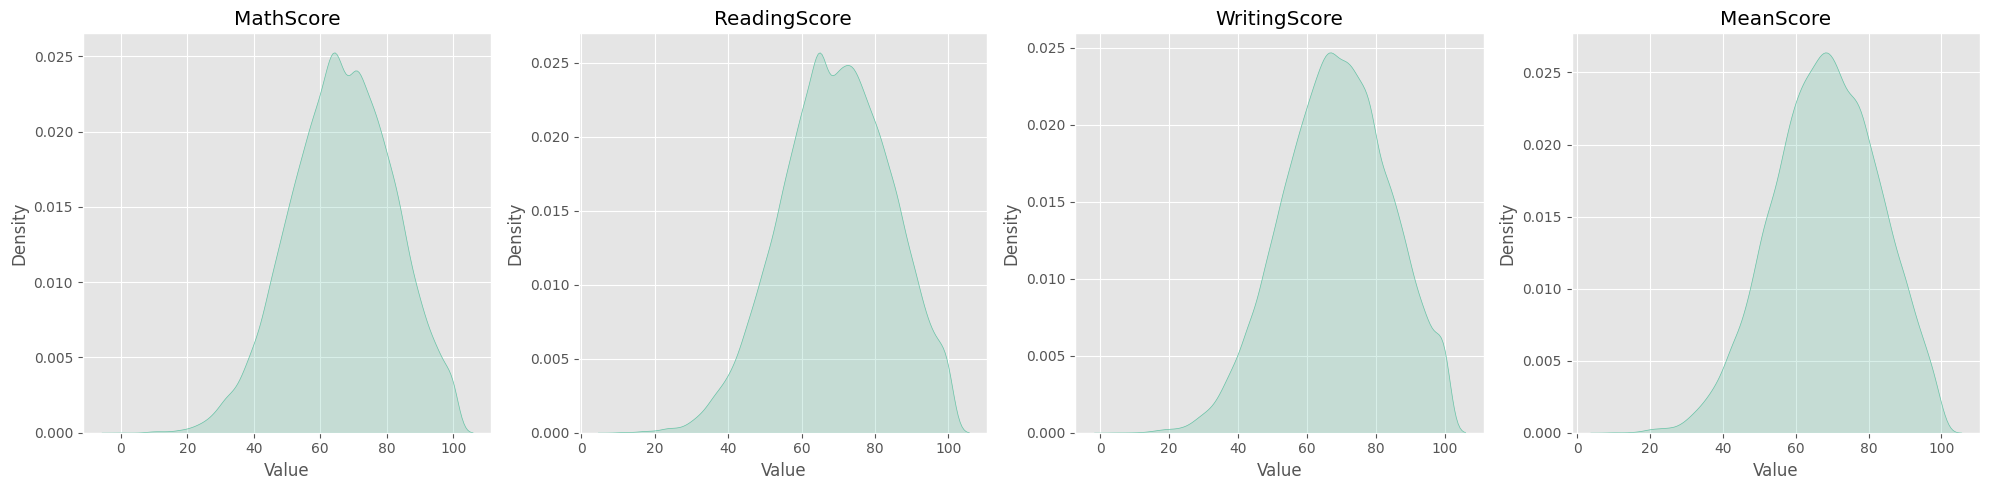

In [30]:
plt.figure(figsize=(20, 5))

for i, column in enumerate(columns, start=1):
    plt.subplot(1, 4, i) 
    sns.kdeplot(df[column], fill=True)
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Density')

plt.tight_layout()
save_plot(plt, f'Numerical-kde.png')
plt.show()


### Visually the data seems to follow a standard 'bell curve' and appears normally distributed, which is very helpful for model fitting.
A standard deviation of 15 indicates the students performance are reasonably close to the mean grade. To further analyse the normal distribution I will plot QQ diagrams below:

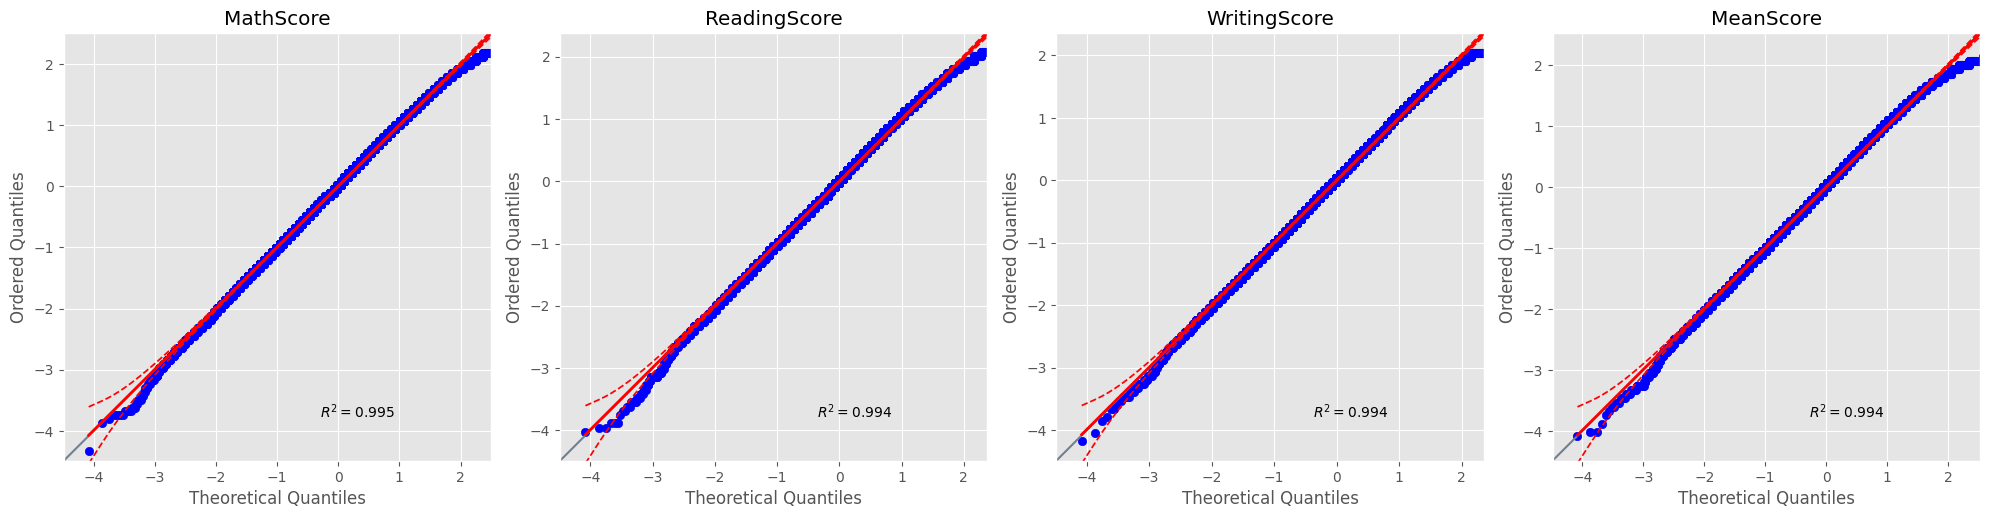

In [34]:
plt.figure(figsize=(20, 5))

for i, column in enumerate(columns, start=1):
    plt.subplot(1, 4, i) 
    data = df[column]
    pg.qqplot(df[column], dist='norm')
    plt.title(column)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Quantiles')

plt.tight_layout()
save_plot(plt, f'Numerical-qq.png')
plt.show()

#### The QQ plots are very closely aligned to the diagonal indicating an very good normal distribution especially around the mean. The values deviate slightly at the ends indicating some possible outliers skewing the normality of the data. This will hopefully not influence any linear regression models to be applied but might need to be dealt with if accuracy becomes an issue.

The R2 value of 0.994+ is also very good indicator of normalness.

Testing for shapiro wilk, we get a dissappointing result:

In [33]:
shapiro_results = []

# Loop and perform the Shapiro-Wilk test
for column in columns:
    test_result = pg.normality(data=df[column], alpha=0.05)
    test_result['Variable'] = column
    shapiro_results.append(test_result)

# add to DataFrame
shapiro_results_df = pd.concat(shapiro_results, ignore_index=True)

shapiro_results_df

/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal,Variable
0,0.995355,2.231806e-29,False,MathScore
1,0.993568,6.197050e-34,False,ReadingScore
2,0.993718,1.361163e-33,False,WritingScore
3,0.994184,1.731815e-32,False,MeanScore


The Shapiro_wilk check seems to indicate that the data is not normal, despite the R2 values and visual confirmation of the Q-Q Plots. However, as the warninig suggests, the test is known to get more sensitive to even small deviations on very large datasets. For this reason, I will press on with the data preparation, under the assumption that data normalcy won't be an issue.